In [1]:
import importlib

import utils
from utils import fit_accuracy_from_task_loss, fit_task_loss_from_ladder_models, plot_actual_vs_predicted, plot_fit
from scaling_laws import default_scaling_law_projection

/Users/nikilravi/miniconda3/envs/crfm_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-27 09:02:20,151	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
ENTITY = "stanford-mercury"
PROJECT = "marin"

# define the list of smaller runs to use as "ladder" models
RUNS = [
    "tootsie-scaling-512-81c36c",
    "tootsie-scaling-768-d17a90",
    "tootsie-scaling-1024-f4e4be",
    "tootsie-scaling-1536-e2a6d8",
    "tootsie-scaling-2048-72c648",
]

# the large run to predict the performance of
PRED_RUN = "llama-8b-tootsie-0.001-19ad63"

# define the eval task loss metric
TASK_LOSS = "eval/paloma/c4_en/bpb"
# TASK_LOSS = "internal_eval/mmlu/bpb"

# do we want to take the last step of the run or average over all steps, or just use all steps?
AGGREGATION = "all"

TOKENS_COL = "throughput/total_tokens"
PARAM_COL = "parameter_count"
PARAM_COL_TO_USE = "computed_params"

# accuracy we ultimately want to predict
TASK_ACCURACY = "lm_eval/hellaswag_10shot/acc"

## Predict task loss from N, D

In [3]:
predicted, points = default_scaling_law_projection(RUNS)

In [4]:
# show each prediction and the point (N, D) it was for
for i, (p, point) in enumerate(zip(predicted, points)):
    print(f"Predicted loss is {p} for N={point.num_params}, D={point.num_tokens}")

Predicted loss is 0.9677903280353168 for N=1400000000, D=700000000
Predicted loss is 0.9537678371870268 for N=1400000000, D=1400000000
Predicted loss is 0.9406559783086549 for N=1400000000, D=2800000000
Predicted loss is 0.924576887926742 for N=1400000000, D=7000000000
Predicted loss is 0.9132673758803347 for N=1400000000, D=14000000000
Predicted loss is 0.9026220525260109 for N=1400000000, D=28000000000
Predicted loss is 0.865190872319983 for N=8000000000, D=4000000000
Predicted loss is 0.8532990167637304 for N=8000000000, D=8000000000
Predicted loss is 0.8421221739893423 for N=8000000000, D=16000000000
Predicted loss is 0.8283397398657746 for N=8000000000, D=40000000000
Predicted loss is 0.8185948407013101 for N=8000000000, D=80000000000
Predicted loss is 0.8093835988618971 for N=8000000000, D=160000000000
Predicted loss is 0.8400185626400398 for N=13000000000, D=6500000000
Predicted loss is 0.828634405916225 for N=13000000000, D=13000000000
Predicted loss is 0.8179208864760097 for N

In [22]:
# def plot_scaling_projections(predicted, points, model_size_idx=None):
#     """Plot scaling law predictions vs tokens for specified or all model sizes"""
#     import matplotlib.pyplot as plt
#     import numpy as np
    
#     tokens = np.array([p.num_tokens for p in points])
#     params = np.array([p.num_params for p in points])
#     predicted = np.array(predicted)
    
#     plt.figure(figsize=(12, 6))
    
#     if model_size_idx is not None:
#         param = params[model_size_idx]
#         tokens = tokens[model_size_idx]
#         plt.plot(tokens, predicted, 'o-', linewidth=2, label=f'{param/1e9:.1f}B params')
#         for t, pred in zip(tokens, predicted):
#             plt.annotate(f'{t/1e12:.1f}T, {pred:.3f}', 
#                         (t, pred),
#                         xytext=(10, 5), 
#                         textcoords='offset points')
#     else:
#         unique_params = np.unique(params)
#         for param in unique_params:
#             mask = params == param
#             plt.plot(tokens[mask], predicted[mask], 'o-', linewidth=2, label=f'{param/1e9:.1f}B params')
#             for t, pred in zip(tokens[mask], predicted[mask]):
#                 plt.annotate(f'{t/1e12:.1f}T, {pred:.3f}', 
#                             (t, pred),
#                             xytext=(10, 5), 
#                             textcoords='offset points')
    
#     plt.xscale('log')
#     plt.xlabel('Number of Tokens')
#     plt.ylabel('Predicted Loss')
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     return plt
def plot_scaling_projections(predicted, points, model_size_idx=None):
    """Plot scaling law predictions vs tokens for specified or all model sizes"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    tokens = np.array([p.num_tokens for p in points])
    params = np.array([p.num_params for p in points])
    predicted = np.array(predicted)
    
    # Group by model size
    unique_params = np.unique(params)
    points_per_model = len(tokens) // len(unique_params)
    
    plt.figure(figsize=(12, 6))
    
    if model_size_idx is not None:
        # Get points for specific model size
        start_idx = model_size_idx * points_per_model
        end_idx = start_idx + points_per_model
        param = unique_params[model_size_idx]
        
        plt.plot(tokens[start_idx:end_idx], predicted[start_idx:end_idx], 'o-', 
                linewidth=2, label=f'{param/1e9:.1f}B params')
        
        for t, pred in zip(tokens[start_idx:end_idx], predicted[start_idx:end_idx]):
            plt.annotate(f'{t/1e12:.1f}T, {pred:.3f}', 
                        (t, pred),
                        xytext=(10, 5), 
                        textcoords='offset points')
    else:
        for i, param in enumerate(unique_params):
            start_idx = i * points_per_model
            end_idx = start_idx + points_per_model
            
            plt.plot(tokens[start_idx:end_idx], predicted[start_idx:end_idx], 
                    'o-', linewidth=2, label=f'{param/1e9:.1f}B params')
            
            for t, pred in zip(tokens[start_idx:end_idx], predicted[start_idx:end_idx]):
                plt.annotate(f'{t/1e9:.1f}B, {pred:.3f}', 
                            (t, pred),
                            xytext=(10, 5), 
                            textcoords='offset points')
    
    plt.xscale('log')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Predicted Loss')
    plt.grid(True)
    plt.legend()

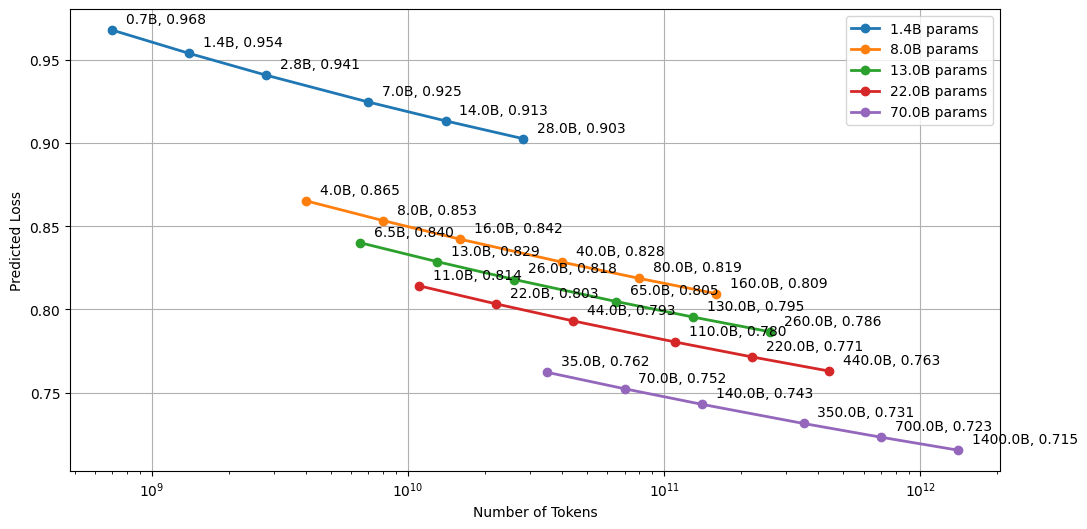

In [23]:
fig = plot_scaling_projections(predicted, points)

In [ ]:
actual, predicted = fit_task_loss_from_ladder_models(
        runs=RUNS,
        entity=ENTITY,
        project=PROJECT,
        metrics=[TASK_LOSS, TOKENS_COL, TASK_ACCURACY],
        pred_run=PRED_RUN,
        task_loss=TASK_LOSS,
        aggregation=AGGREGATION,
        tokens_col=TOKENS_COL,
        param_col=PARAM_COL,
        param_col_to_use=PARAM_COL,
        use_log_for_ND=True,
        normalize_ND=True,
    )

plot_actual_vs_predicted(actual, predicted, title="Prediction on 7B Run using 5-sub 1.4B ladder models")

In [ ]:
plot_fit(actual, predicted, title="Prediction on 7B Run using 5-sub 1.4B ladder models")

## Predict task accuracy from task loss

In [ ]:
importlib.reload(utils)


# get accuracy, which is hellaswag accuracy
actual_acc, pred_acc = fit_accuracy_from_task_loss(
    pred_task_losses=predicted,
    runs=RUNS,
    entity=ENTITY,
    project=PROJECT,
    x_axis="throughput/total_gflops",
    tokens_col=TOKENS_COL,
    pred_run=PRED_RUN,
    aggregation=AGGREGATION,
    task_loss_col=TASK_LOSS,
    accuracy_col=TASK_ACCURACY,
)

In [ ]:
plot_actual_vs_predicted(
    actual_acc, pred_acc,
    title="Prediction on 7B Run using 5-sub 1.4B ladder models",
    task_metric=TASK_ACCURACY
)